In [ ]:
#dataset link https://www.kaggle.com/datasets/harshalgadhe/poem-generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [2]:
!unzip /content/poem_generation.zip

Archive:  /content/poem_generation.zip
  inflating: poem.txt                


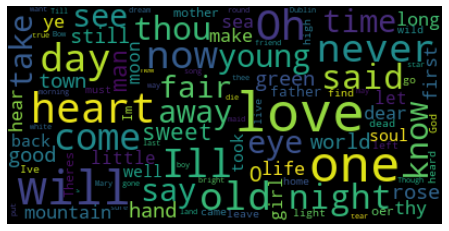

In [3]:
# Reading the text data file
data = open('poem.txt', encoding="utf8").read()
  
# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(data)
  
# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [4]:
# Generating the corpus by 
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [5]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
  
# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)
  
print("Total Words:", total_words)

Total Words: 3807


In [6]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
  
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
  
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
                                         maxlen=max_sequence_len,
                                         padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

In [7]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100, 
                    input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           380800    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3807)              384507    
                                                                 
 dense_1 (Dense)             (None, 3808)              14500864  
                                                        

In [8]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
510/510 [==============================] - 107s 200ms/step - loss: 6.9437 - accuracy: 0.0618
Epoch 2/150
510/510 [==============================] - 98s 193ms/step - loss: 6.5187 - accuracy: 0.0638
Epoch 3/150
510/510 [==============================] - 100s 196ms/step - loss: 6.3348 - accuracy: 0.0649
Epoch 4/150
510/510 [==============================] - 99s 194ms/step - loss: 6.2186 - accuracy: 0.0714
Epoch 5/150
510/510 [==============================] - 100s 196ms/step - loss: 6.1189 - accuracy: 0.0805
Epoch 6/150
510/510 [==============================] - 99s 193ms/step - loss: 6.0201 - accuracy: 0.0847
Epoch 7/150
510/510 [==============================] - 99s 194ms/step - loss: 5.9167 - accuracy: 0.0932
Epoch 8/150
510/510 [==============================] - 99s 194ms/step - loss: 5.8088 - accuracy: 0.1012
Epoch 9/150
510/510 [==============================] - 102s 200ms/step - loss: 5.7144 - accuracy: 0.1072
Epoch 10/150
510/510 [==============================] - 100s

In [10]:
seed_text = "Friendship"
next_words = 25
ouptut_text = ""
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
        [token_list], maxlen=max_sequence_len-1,
      padding='pre')
    predicted = np.argmax(model.predict(token_list, 
                                        verbose=0), axis=-1)
    output_word = ""
      
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
              
    seed_text += " " + output_word
      
print(seed_text)

Friendship the moon through the valley her pale rays was shedding thus she care to me only loved him for good good night young good road


In [11]:
model.save('poem.h5')